# Camera Calibration

In [1]:
import math
import glob
import os
import cv2 as cv
import matplotlib.pylab as plt
import numpy as np

## Data overview

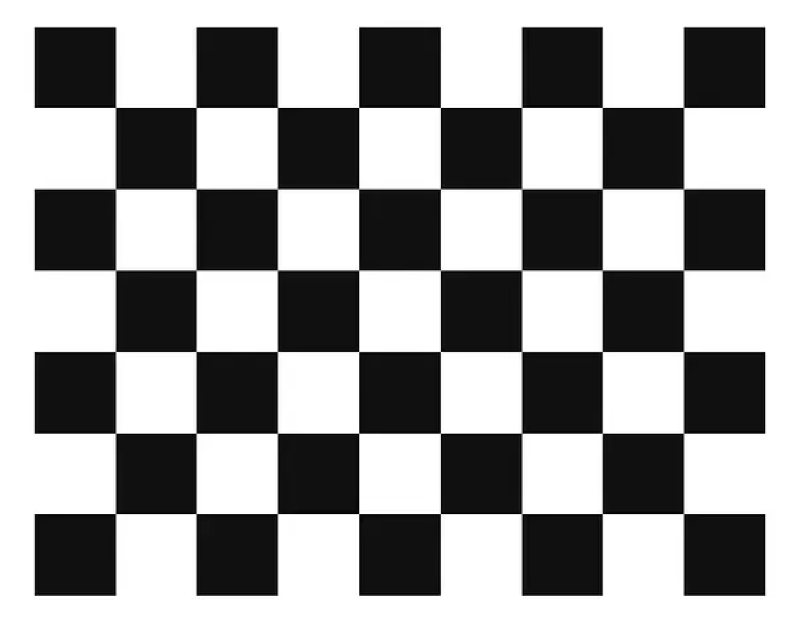

In [2]:
checkerboard = cv.imread("../data/calibration/checkerboard.png", cv.IMREAD_GRAYSCALE)

# Display the image
plt.figure(figsize=(10, 10))  # Adjust size as needed
plt.imshow(checkerboard, cmap='gray')
plt.axis('off')  # Hide axes

plt.show()

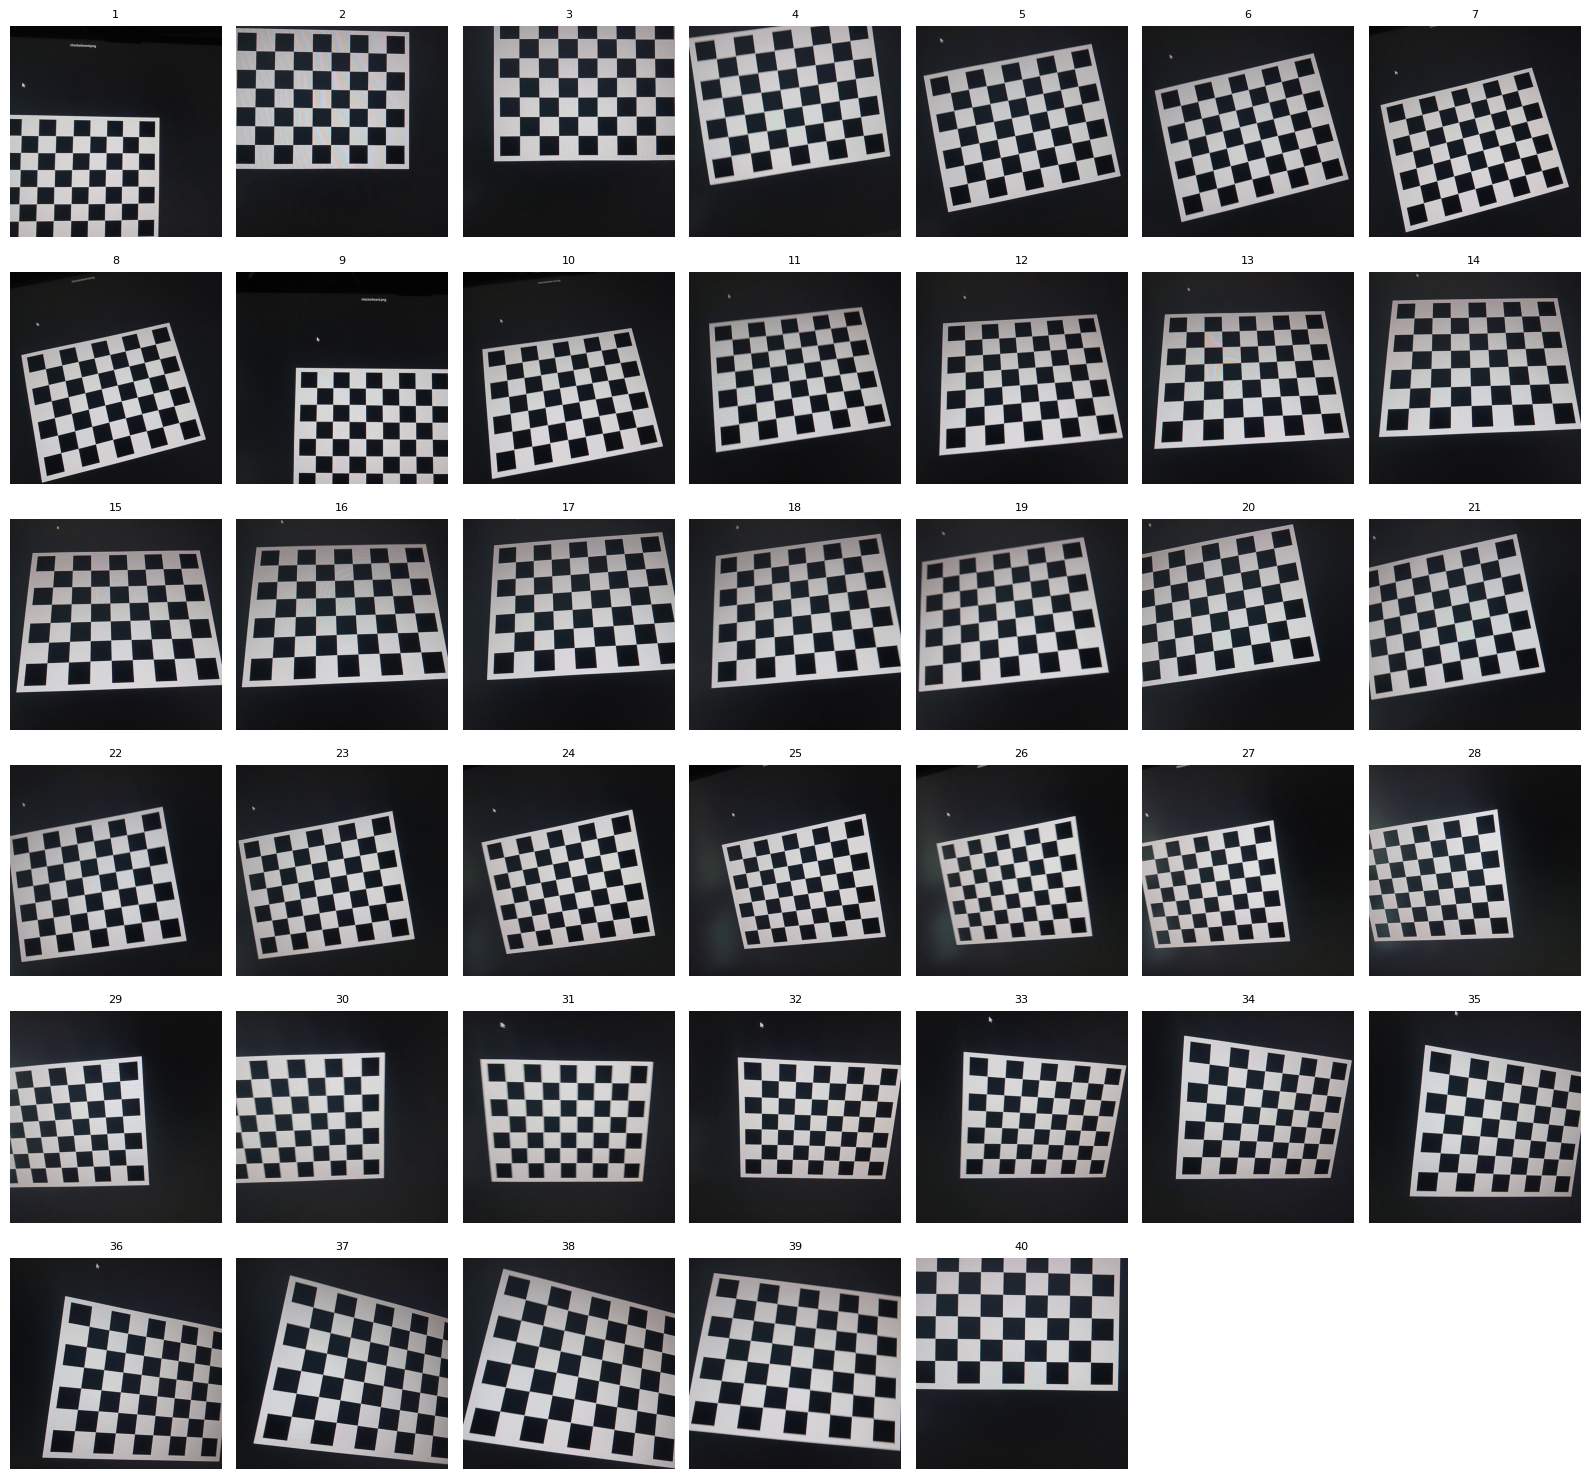

In [3]:
IMAGE_FOLDER = "../data/calibration/images"  # path to folder with images
image_paths = sorted(glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg")))  # or .png

# Number of columns (thumbnails per row)
cols = 7
rows = math.ceil(len(image_paths) / cols)

# Create figure
plt.figure(figsize=(16, 2.5 * rows))  # Adjust height dynamically based on number of rows

for i, img_path in enumerate(image_paths):
    # Load and convert image to RGB for display
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    
    # Add subplot
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{i+1}", fontsize=8)  # Optional: index as title

plt.tight_layout()
plt.show()

## Camera Model

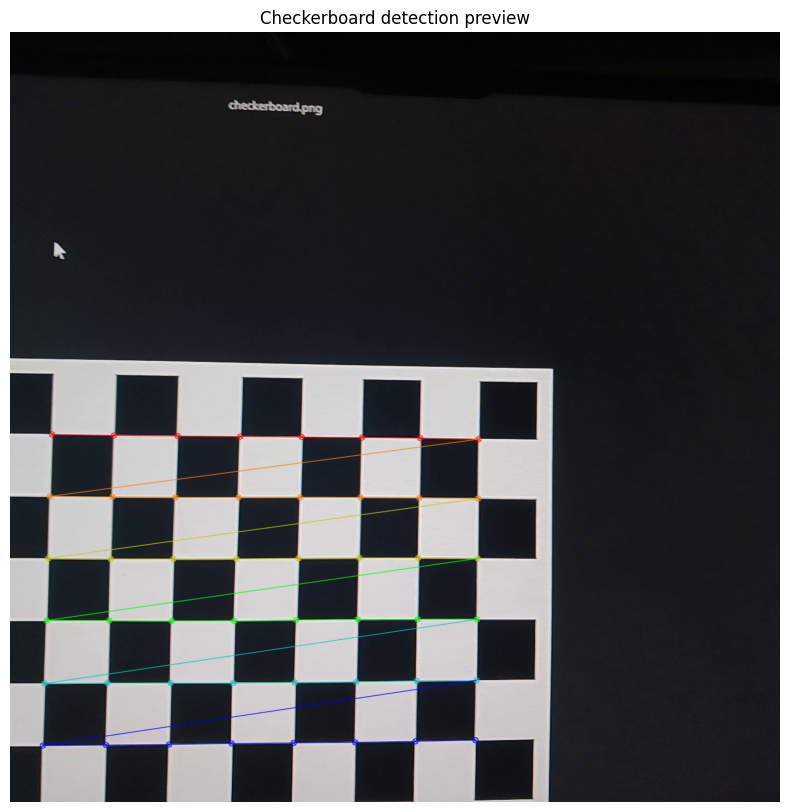

Processed 40 images. Found corners in 37 images.
Calibration finished.
Reprojection error (RMS): 1.0080032505879182
Camera matrix:
 [[1.56410132e+03 0.00000000e+00 7.43315803e+02]
 [0.00000000e+00 1.56724702e+03 6.88616621e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 3.07340374e-01 -1.85791430e+00 -7.81409788e-05 -1.75578046e-03
   3.02473074e+00]]


In [4]:
# === PARAMETERS ===
CHECKERBOARD_SIZE = (8, 6)  # inner corners

# termination criteria for corner refinement
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points (0,0,0), (1,0,0), (2,0,0), ... in grid
product = CHECKERBOARD_SIZE[0] * CHECKERBOARD_SIZE[1]
objp = np.zeros((product, 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)

# storage for calibration points
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

preview = False


if len(image_paths) == 0:
    print(f"Error: No images found in {IMAGE_FOLDER}")
else:
    for img_path in image_paths:
        frame = cv.imread(img_path)  # BGR
        gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # find the chessboard corners
        ret, corners = cv.findChessboardCorners(gray_frame, CHECKERBOARD_SIZE, None)

        if ret:
            objpoints.append(objp)
            # refine corner positions
            corners2 = cv.cornerSubPix(gray_frame, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # preview first successful detection
            if not preview:
                cv.drawChessboardCorners(frame, CHECKERBOARD_SIZE, corners2, ret)
                plt.figure(figsize=(10, 10))
                plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title("Checkerboard detection preview")
                plt.show()
                preview = True

    print(f"Processed {len(image_paths)} images. Found corners in {len(imgpoints)} images.")

    # === CALIBRATE CAMERA ===
    if len(imgpoints) > 0:
        ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
            objpoints, imgpoints, gray_frame.shape[::-1], None, None
        )
        print("Calibration finished.")
        print("Reprojection error (RMS):", ret)
        print("Camera matrix:\n", mtx)
        print("Distortion coefficients:\n", dist)
    else:
        print("Error: No checkerboard corners detected, cannot calibrate.")


## Application to Real Image

Original size: 1440 x 1440


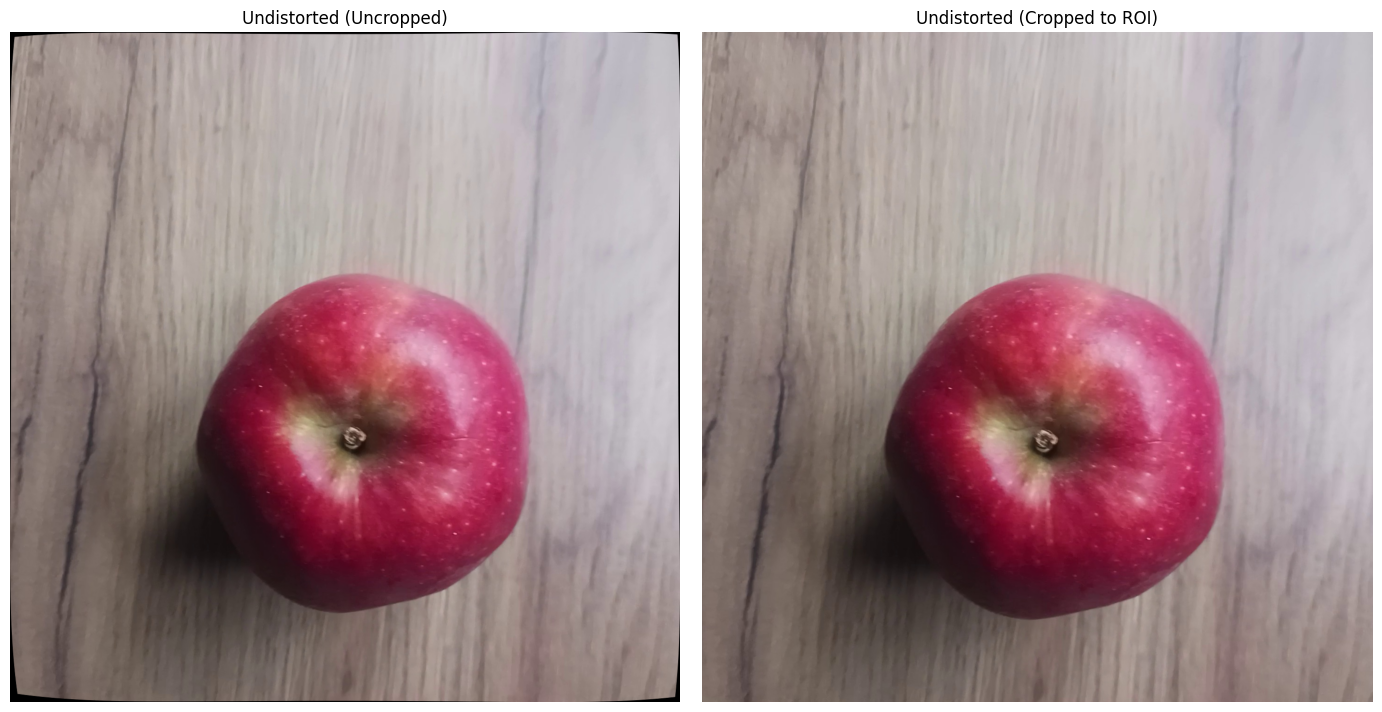

In [5]:
# Load image and convert to RGB
image = cv.cvtColor(cv.imread("../data/calibration/test.jpg"), cv.COLOR_BGR2RGB)

h, w = image.shape[:2]
print(f"Original size: {h} x {w}")

# Compute new optimal camera matrix
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistort
dst = cv.undistort(image, mtx, dist, None, newcameramtx)

# Crop the image based on ROI
x, y, w_roi, h_roi = roi
calibrated_image = dst[y:y + h_roi, x:x + w_roi]

# === Plot side-by-side ===
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Uncropped
axes[0].imshow(dst)
axes[0].set_title("Undistorted (Uncropped)")
axes[0].axis('off')

# Cropped
axes[1].imshow(calibrated_image)
axes[1].set_title("Undistorted (Cropped to ROI)")
axes[1].axis('off')

plt.tight_layout()
plt.show()